In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

  Running setup.py bdist_wheel for sklearn ... - done
  Stored in directory: /content/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

In [0]:
from keras.models import Model
from keras.layers import *
from keras.activations import *

In [0]:
def get_gru_last_step(lstm_sequences):
    return Lambda(lambda sequence: sequence[:, -1, :])(lstm_sequences)

def classification_block(input_layer, dropout_rate=0.2):
    model = Dense(256, activation='linear',
                  kernel_initializer='he_normal')(input_layer)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)

    model = Dense(256, activation='linear',
                  kernel_initializer='he_normal')(model)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)

    return Dense(6, activation='sigmoid', kernel_initializer='glorot_normal')(model)

In [0]:
max_words = 30000
max_words_length = 400
embedding_dimension = 300

gru_options = {
    'units': 300,
    'dropout': 0.2,
    'return_sequences': True
}

In [11]:
input_layer = Input(shape=(max_words_length,))

pretrained_embedding_layer = Embedding(
    max_words,
    output_dim=embedding_dimension,
    input_length=max_words_length,
    weights=[np.load('fast_text_embeddings.npy')],
    trainable=False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    max_words,
    output_dim=embedding_dimension,
    input_length=max_words_length,
    weights=[np.load('custom_fast_text_embeddings.npy')],
    trainable=False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

averaged_embedding_layer = Average()([pretrained_embedding_layer, custom_embedding_layer])
averaged_embedding_layer = SpatialDropout1D(0.2)(averaged_embedding_layer)

gru = Bidirectional(
  CuDNNGRU(
    units=gru_options['units'],
    return_sequences=gru_options['return_sequences']
  )
)(averaged_embedding_layer)
gru = Dropout(gru_options['dropout'])(gru)

pooled_features_1 = concatenate([
    GlobalMaxPooling1D()(gru),
    GlobalAveragePooling1D()(gru),
    get_gru_last_step(gru)
])

gru = Bidirectional(
  CuDNNGRU(
    units=gru_options['units'],
    return_sequences=gru_options['return_sequences']
  )
)(gru)
gru = Dropout(gru_options['dropout'])(gru)

pooled_features_2 = concatenate([
    GlobalMaxPooling1D()(gru),
    GlobalAveragePooling1D()(gru),
    get_gru_last_step(gru)
])

pooled_features = concatenate([pooled_features_1, pooled_features_2])
pooled_features = Dropout(0.2)(pooled_features)

output_layer = classification_block(pooled_features, dropout_rate=0.2)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(loss='binary_crossentropy', 
            optimizer='Adam',
            metrics=['accuracy'])          

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [12]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 21312/102124 [=====>........................] - ETA: 21:11 - loss: 0.1144 - acc: 0.9609

102112/102124 [============================>.] - ETA: 0s - loss: 0.0699 - acc: 0.9753

102124/102124 [==============================] - 1729s 17ms/step - loss: 0.0699 - acc: 0.9753 - val_loss: 0.0510 - val_acc: 0.9812
Epoch 2/32
 10080/102124 [=>............................] - ETA: 23:57 - loss: 0.0537 - acc: 0.9806

102112/102124 [============================>.] - ETA: 0s - loss: 0.0509 - acc: 0.9811

102124/102124 [==============================] - 1728s 17ms/step - loss: 0.0509 - acc: 0.9811 - val_loss: 0.0438 - val_acc: 0.9834
roc-auc: 0.9864 - roc-auc_val: 0.9831                                                                                                    
Epoch 3/32
  8640/102124 [=>............................] - ETA: 24:22 - loss: 0.0476 - acc: 0.9823

102112/102124 [============================>.] - ETA: 0s - loss: 0.0462 - acc: 0.9825

102124/102124 [==============================] - 1730s 17ms/step - loss: 0.0461 - acc: 0.9825 - val_loss: 0.0405 - val_acc: 0.9844
Epoch 4/32
 10080/102124 [=>............................] - ETA: 23:57 - loss: 0.0446 - acc: 0.9830

102112/102124 [============================>.] - ETA: 0s - loss: 0.0438 - acc: 0.9832

102124/102124 [==============================] - 1726s 17ms/step - loss: 0.0438 - acc: 0.9832 - val_loss: 0.0425 - val_acc: 0.9838
roc-auc: 0.9915 - roc-auc_val: 0.9877                                                                                                    
Epoch 5/32
  8640/102124 [=>............................] - ETA: 24:19 - loss: 0.0416 - acc: 0.9840

102112/102124 [============================>.] - ETA: 0s - loss: 0.0410 - acc: 0.9840

102124/102124 [==============================] - 1727s 17ms/step - loss: 0.0410 - acc: 0.9840 - val_loss: 0.0455 - val_acc: 0.9829

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003298769879620522.
Epoch 6/32
  7968/102124 [=>............................] - ETA: 24:30 - loss: 0.0404 - acc: 0.9842

102112/102124 [============================>.] - ETA: 0s - loss: 0.0396 - acc: 0.9844

102124/102124 [==============================] - 1726s 17ms/step - loss: 0.0397 - acc: 0.9844 - val_loss: 0.0432 - val_acc: 0.9839
roc-auc: 0.9936 - roc-auc_val: 0.9886                                                                                                    
Epoch 7/32
  8640/102124 [=>............................] - ETA: 24:19 - loss: 0.0359 - acc: 0.9857

102112/102124 [============================>.] - ETA: 0s - loss: 0.0378 - acc: 0.9851

102124/102124 [==============================] - 1725s 17ms/step - loss: 0.0378 - acc: 0.9851 - val_loss: 0.0452 - val_acc: 0.9834
Epoch 8/32
 10080/102124 [=>............................] - ETA: 23:46 - loss: 0.0445 - acc: 0.9831

102112/102124 [============================>.] - ETA: 0s - loss: 0.0396 - acc: 0.9847

102124/102124 [==============================] - 1718s 17ms/step - loss: 0.0396 - acc: 0.9847 - val_loss: 0.0496 - val_acc: 0.9817
roc-auc: 0.9942 - roc-auc_val: 0.9881                                                                                                    
Epoch 9/32
  8640/102124 [=>............................] - ETA: 24:08 - loss: 0.0386 - acc: 0.9850

102112/102124 [============================>.] - ETA: 0s - loss: 0.0369 - acc: 0.9854

102124/102124 [==============================] - 1718s 17ms/step - loss: 0.0369 - acc: 0.9854 - val_loss: 0.0496 - val_acc: 0.9823
Epoch 10/32
 10048/102124 [=>............................] - ETA: 23:48 - loss: 0.0373 - acc: 0.9851

102112/102124 [============================>.] - ETA: 0s - loss: 0.0354 - acc: 0.9858

102124/102124 [==============================] - 1716s 17ms/step - loss: 0.0354 - acc: 0.9858 - val_loss: 0.0431 - val_acc: 0.9844
roc-auc: 0.9953 - roc-auc_val: 0.9872                                                                                                    
Epoch 11/32
  8608/102124 [=>............................] - ETA: 24:12 - loss: 0.0328 - acc: 0.9871

102112/102124 [============================>.] - ETA: 0s - loss: 0.0339 - acc: 0.9865

102124/102124 [==============================] - 1719s 17ms/step - loss: 0.0339 - acc: 0.9865 - val_loss: 0.0492 - val_acc: 0.9830
Epoch 12/32
 10048/102124 [=>............................] - ETA: 23:52 - loss: 0.0329 - acc: 0.9865

102112/102124 [============================>.] - ETA: 0s - loss: 0.0326 - acc: 0.9869

102124/102124 [==============================] - 1723s 17ms/step - loss: 0.0326 - acc: 0.9869 - val_loss: 0.0447 - val_acc: 0.9841
roc-auc: 0.9966 - roc-auc_val: 0.9882                                                                                                    
Epoch 13/32
  8608/102124 [=>............................] - ETA: 24:15 - loss: 0.0308 - acc: 0.9882

102112/102124 [============================>.] - ETA: 0s - loss: 0.0310 - acc: 0.9877

102124/102124 [==============================] - 1722s 17ms/step - loss: 0.0310 - acc: 0.9877 - val_loss: 0.0459 - val_acc: 0.9838


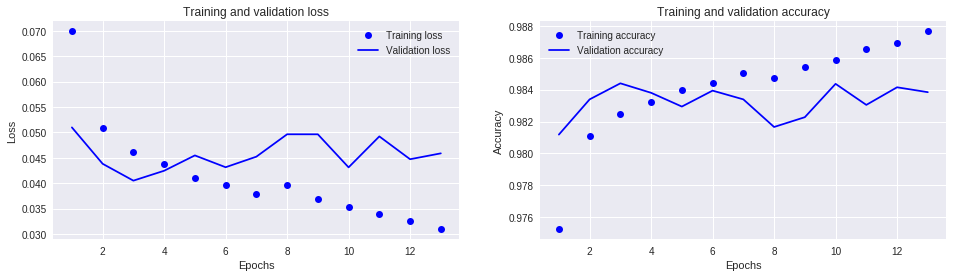

In [13]:
plot_history(history)

In [14]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 170s 5ms/step
([0.04464225013670034, 0.9844534819969913], 0.9889101520447691)
